In [1]:
import mdtraj
import numpy as np
import matplotlib.pyplot as plt
import nglview
import sys
sys.path.append('../')
from Simulation.helper_functions import minimize_mol, calculate_DGv3, get_cluster_asignments_ordered, in_kjmol, get_dihedrals_by_name
from rdkit import Chem
from rdkit.Chem import AllChem
import nglview
import yaml
from copy import deepcopy

solvent_dict = yaml.load(open("../Simulation/solvents.yml"), Loader=yaml.FullLoader)[
    "solvent_mapping_dict"
]

from ebc import EBC
import tqdm
from typing import DefaultDict
from matplotlib import cm
def get_color_from_sd(sd):
    return cm.RdBu(sd/80)

from Simulation.helper_functions import minimize_mol
from rdkit.Geometry import Point3D
all_smiles = list(
    np.loadtxt(
        "../Simulation/simulation_smiles/conformational_ensemble_smiles.txt",
        dtype=str,
        comments=None,
    )
)
def get_mol(smiles, num_confs=1024):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    if num_confs > 0:
        AllChem.EmbedMultipleConfs(
            mol, numConfs=num_confs, randomSeed=42, useExpTorsionAnglePrefs=False
        )
    return mol

def get_mol_from_traj(traj,smiles):
    mol = get_mol(smiles,num_confs=traj.n_frames)
    for i in range(traj.n_frames):
        conf = mol.GetConformer(i)
        for a in range(mol.GetNumAtoms()):
            conf.SetAtomPosition(a,Point3D(float(traj.xyz[i][a][0])*10,float(traj.xyz[i][a][1])*10,float(traj.xyz[i][a][2])*10))
    return mol

from sklearn.metrics import confusion_matrix as sklearn_confusion_matrix

def get_metrics(pre,ref,selection):
    kbt = 2.479

    count_below_kbt = np.abs(pre-ref) < kbt
    pre = pre < selection
    ref = ref < selection
    confm = sklearn_confusion_matrix(ref,pre)

    # Get important metrics
    if confm.shape == (1,1):
        confm = np.array([[confm[0][0],0],[0,0]])
    tn, fp, fn, tp = confm.ravel()

    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    balanced_accuracy = (tp/(tp+fn) + tn/(tn+fp))/2

    # Pearson R
    pre = pre.astype(float)
    ref = ref.astype(float)
    from scipy.stats import pearsonr
    pearson_r = pearsonr(pre,ref)[0]

    return (accuracy,precision,recall,balanced_accuracy,count_below_kbt.mean(),pearson_r)

In [2]:
plot_folder = "/fileserver/pine/pine8/kpaul/multi_solvent_pub/manuscript/Plots/"

# Set C

In [ ]:
comparison_folder = "/fileserver/pine/pine8/kpaul/multi_solvent_pub/data/REST2/conformational_ensemble_rdkit2023/conformational_ensemble/"
minimization_folder = "/fileserver/pine/pine8/kpaul/multi_solvent_pub/data/Minimizations/conformational_ensemble/"

In [4]:
conf_results_dict = DefaultDict(dict)
rest2_map = {"tip3p": "water", "Chloroform": "chloroform", "DMSO": "dmso", "Methanol": "co"}
lims = 10
for id in range(5):

    mol = Chem.MolFromSmiles(all_smiles[id])
    permutations = mol.GetSubstructMatches(mol,useChirality=True,uniquify=False)

    for gnn_solvent in ["tip3p","Chloroform","DMSO","Methanol"]:
        try:
            cluster_center_traj = mdtraj.load(f"{minimization_folder}conformational_ensemble_id_{id}/conformational_ensemble_id_{id}_{gnn_solvent}_seed_42_cluster_center.h5")
            cluster_energies = np.load(f"{minimization_folder}conformational_ensemble_id_{id}/conformational_ensemble_id_{id}_{gnn_solvent}_seed_42_cluster_center_free_energy.npy")
            cluster_energies = np.array(cluster_energies) - np.min(cluster_energies)
            comparison_traj = mdtraj.load(comparison_folder + "conformational_ensembl_%s_%i/ensemble-0.xtc" % (rest2_map[gnn_solvent],id),top=cluster_center_traj.top)

            cluster_center_traj = cluster_center_traj[cluster_energies<lims]
            cluster_energies = cluster_energies[cluster_energies<lims]

            full_rmsd = np.zeros((len(cluster_center_traj),comparison_traj.n_frames))
            selection_comparison = comparison_traj.top.select("element != H")
            selection_gnn = cluster_center_traj.top.select("element != H")

            for i, traj in tqdm.tqdm(enumerate(cluster_center_traj)):
                rmsds = np.zeros((len(permutations),comparison_traj.n_frames))
                for p,permutation in enumerate(permutations):
                    rmsds[p] = mdtraj.rmsd(comparison_traj,traj,atom_indices=selection_comparison,ref_atom_indices=permutation)
                full_rmsd[i] = np.min(rmsds,axis=0)

            conf_results_dict[gnn_solvent][id] = (full_rmsd,cluster_energies)
        except Exception as e:
            print(e)


/localhome/kpaul/.conda/envs/GNNImplicitSolvent/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')
22it [00:01, 16.05it/s]
13it [00:00, 18.46it/s]
17it [00:00, 18.72it/s]
20it [00:01, 17.78it/s]
17it [00:00, 24.33it/s]
8it [00:00, 25.47it/s]
14it [00:00, 22.85it/s]
15it [00:00, 26.12it/s]
7it [00:00, 12.96it/s]
6it [00:00, 12.52it/s]
5it [00:00, 10.74it/s]
6it [00:00, 11.17it/s]
15it [00:00, 16.04it/s]
4it [00:00, 14.88it/s]
11it [00:00, 14.09it/s]
12it [00:00, 15.33it/s]
8it [00:00, 31.21it/s]
2it [00:00, 28.11it/s]
6it [00:00, 31.28it/s]
6it [00:00, 30.19it/s]


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


/tmp/ipykernel_1082213/1687287115.py:55: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axd["%s_cor_id_%i"%(solvent,id)].scatter(exp_energies,pre_energies,zorder=3,s=20,
/tmp/ipykernel_1082213/1687287115.py:55: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axd["%s_cor_id_%i"%(solvent,id)].scatter(exp_energies,pre_energies,zorder=3,s=20,
/tmp/ipykernel_1082213/1687287115.py:55: UserWarning: *c* argument looks like a single num

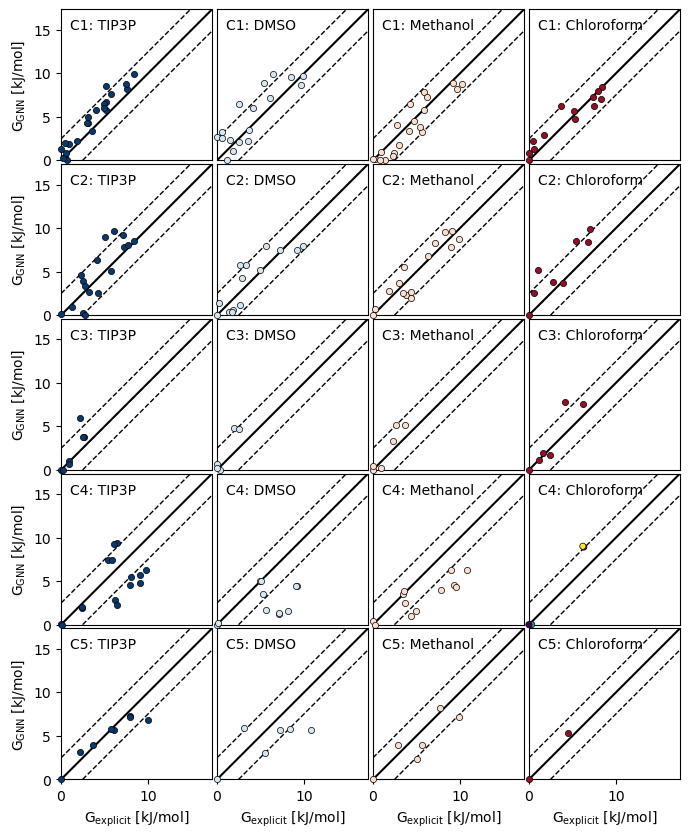

In [19]:
fig, axd = plt.subplot_mosaic([
                            ["tip3p_cor_id_%i"%id,"DMSO_cor_id_%i"%id,"Methanol_cor_id_%i"%id,"Chloroform_cor_id_%i"%id]
                             for id in range(5) if not id in [5]],figsize=(8,10))

all_exp_energies_std = []
all_all_exp_energies = []
all_pl_pre_energies = []
all_pl_exp_energies = []
all_1kbt = []
all_2kbt = []
all_confusion_matrices = DefaultDict(dict)
balanced_accuracies_C = []

for id in range(5):
    for solvent in ["tip3p","DMSO","Methanol","Chloroform"]:

        full_rmsd, cluster_energies= conf_results_dict[solvent][id]

        kbt = 2.479
        lims = 5*kbt
        lim = 7*kbt
        all_exp_energies = []

        iterator = [0.1]

        for thr in iterator:
            
            population_bin = np.bincount(np.argmin(full_rmsd,axis=0)[np.min(full_rmsd,axis=0)<thr])
            population = np.zeros(full_rmsd.shape[0])
            population[:population_bin.shape[0]] = population_bin

            # population = (full_rmsd < thr).sum(axis=1)
            pre_energies = cluster_energies-np.min(cluster_energies)
            exp_energies = in_kjmol(population,False) - np.min(in_kjmol(population,False))
            selection = (pre_energies < lims)
            exp_energies = exp_energies[selection]
            pre_energies = pre_energies[selection]

            all_exp_energies.append(exp_energies)
        
        
        all_exp_energies = np.stack(all_exp_energies)
        all_exp_energies[all_exp_energies == np.inf] = np.max(all_exp_energies[all_exp_energies != np.inf])
        all_all_exp_energies.append(all_exp_energies)

        exp_energies = np.nanmean(all_exp_energies,axis=0)
        exp_energies = exp_energies - np.nanmin(exp_energies)
        exp_energies_std = np.nanstd(all_exp_energies,axis=0)
        all_exp_energies_std.append(exp_energies_std)

        all_pl_pre_energies.append(pre_energies)
        all_pl_exp_energies.append(exp_energies)
        print(np.isnan(exp_energies).sum())

        axd["%s_cor_id_%i"%(solvent,id)].scatter(exp_energies,pre_energies,zorder=3,s=20,
                                                clip_on=False,c=get_color_from_sd(solvent_dict[solvent]['dielectric']),
                                                marker='o',edgecolors='black',linewidths=0.5)
        balanced_accuracies_C.append(get_metrics(pre_energies,exp_energies,kbt)[3])

        axd["%s_cor_id_%i"%(solvent,id)].axline([0,0],[1,1],color='black')
        axd["%s_cor_id_%i"%(solvent,id)].axline([0,kbt],[1,1+kbt],color='black',linestyle='--',linewidth=1)
        axd["%s_cor_id_%i"%(solvent,id)].axline([0,-kbt],[1,1-kbt],color='black',linestyle='--',linewidth=1)
        axd["%s_cor_id_%i"%(solvent,id)].set_xlim(0,lim)
        axd["%s_cor_id_%i"%(solvent,id)].set_ylim(0,lim)
        axd["%s_cor_id_%i"%(solvent,id)].set_xlabel('$\mathrm{G_{explicit}}$ [kJ/mol]')
        axd["%s_cor_id_%i"%(solvent,id)].set_ylabel('$\mathrm{G_{GNN}}$ [kJ/mol]')
        axd["%s_cor_id_%i"%(solvent,id)].set_aspect('equal', adjustable='box')
        coverage = (full_rmsd[selection] < 0.075).any(axis=0).mean()
        axd["%s_cor_id_%i"%(solvent,id)].text(1,15,"C%i: %s"%(id+1,solvent_dict[solvent]["nice_name"]))
        # axd["%s_cor_id_%i"%(solvent,id)].text(1,15,"$\mathrm{Err_{explicit}}$: %.1f kJ/mol"%np.nanmean(exp_energies_std),fontsize=8)
        # axd["%s_cor_id_%i"%(solvent,id)].text(1,14,"Coverage: %.2f"% coverage,fontsize=8)

        # calculate confusion matrix
        allc = []
        for confusion_lim in range(6):
            confusion_matrix = np.zeros((2,2))
            confusion_matrix[0,0] = ((exp_energies <= confusion_lim) & (pre_energies <= confusion_lim)).sum()
            confusion_matrix[0,1] = ((exp_energies < confusion_lim) & (pre_energies > confusion_lim)).sum()
            confusion_matrix[1,0] = ((exp_energies > confusion_lim) & (pre_energies < confusion_lim)).sum()
            confusion_matrix[1,1] = ((exp_energies > confusion_lim) & (pre_energies > confusion_lim)).sum()
            allc.append(confusion_matrix)
        all_confusion_matrices[id][solvent] = allc

        all_1kbt.append(np.sum(exp_energies[pre_energies < 2.479] == 0))
        all_2kbt.append(np.sum(exp_energies[pre_energies < 2.479*2] == 0))


for ax in axd.values():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

for key in axd.keys():
    if "tip3p" in key:
        axd[key].get_yaxis().set_visible(True)
    if "id_4" in key:
        axd[key].get_xaxis().set_visible(True)

plt.subplots_adjust(wspace=0.025, hspace=0.025)

fig.savefig(plot_folder + "/conformational_ensemble_correlation_gnn_exp.pdf",bbox_inches='tight')

0


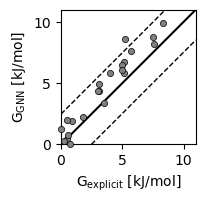

In [20]:
fig, axd = plt.subplot_mosaic([
                            ["tip3p_cor_id_%i"%id]
                             for id in range(1)],figsize=(2,1.75))

all_exp_energies_std = []
all_all_exp_energies = []
all_pl_pre_energies = []
all_pl_exp_energies = []
all_1kbt = []
all_2kbt = []
all_confusion_matrices = DefaultDict(dict)

for id in range(1):
    for solvent in ["tip3p"]:#,"DMSO","Methanol","Chloroform"]:

        full_rmsd, cluster_energies= conf_results_dict[solvent][id]

        kbt = 2.479
        lims = 5*kbt
        lim = 11
        all_exp_energies = []

        iterator = [0.1]

        for thr in iterator:
            
            population_bin = np.bincount(np.argmin(full_rmsd,axis=0)[np.min(full_rmsd,axis=0)<thr])
            population = np.zeros(full_rmsd.shape[0])
            population[:population_bin.shape[0]] = population_bin

            # population = (full_rmsd < thr).sum(axis=1)
            pre_energies = cluster_energies-np.min(cluster_energies)
            exp_energies = in_kjmol(population,False) - np.min(in_kjmol(population,False))
            selection = (pre_energies < lims)
            exp_energies = exp_energies[selection]
            pre_energies = pre_energies[selection]

            all_exp_energies.append(exp_energies)
        
        
        all_exp_energies = np.stack(all_exp_energies)
        all_exp_energies[all_exp_energies == np.inf] = np.max(all_exp_energies[all_exp_energies != np.inf])
        all_all_exp_energies.append(all_exp_energies)

        exp_energies = np.nanmean(all_exp_energies,axis=0)
        exp_energies = exp_energies - np.nanmin(exp_energies)
        exp_energies_std = np.nanstd(all_exp_energies,axis=0)
        all_exp_energies_std.append(exp_energies_std)

        all_pl_pre_energies.append(pre_energies)
        all_pl_exp_energies.append(exp_energies)
        print(np.isnan(exp_energies).sum())

        axd["%s_cor_id_%i"%(solvent,id)].scatter(exp_energies,pre_energies,zorder=3,s=20,
                                                clip_on=False,c="grey",
                                                marker='o',edgecolors='black',linewidths=0.5)

        axd["%s_cor_id_%i"%(solvent,id)].axline([0,0],[1,1],color='black')
        axd["%s_cor_id_%i"%(solvent,id)].axline([0,kbt],[1,1+kbt],color='black',linestyle='--',linewidth=1)
        axd["%s_cor_id_%i"%(solvent,id)].axline([0,-kbt],[1,1-kbt],color='black',linestyle='--',linewidth=1)
        axd["%s_cor_id_%i"%(solvent,id)].set_xlim(0,lim)
        axd["%s_cor_id_%i"%(solvent,id)].set_ylim(0,lim)
        axd["%s_cor_id_%i"%(solvent,id)].set_xlabel('$\mathrm{G_{explicit}}$ [kJ/mol]')
        axd["%s_cor_id_%i"%(solvent,id)].set_ylabel('$\mathrm{G_{GNN}}$ [kJ/mol]')
        axd["%s_cor_id_%i"%(solvent,id)].set_aspect('equal', adjustable='box')
        coverage = (full_rmsd[selection] < 0.075).any(axis=0).mean()
        # axd["%s_cor_id_%i"%(solvent,id)].text(1,15,"C%i: %s"%(id+1,solvent_dict[solvent]["nice_name"]))
        # axd["%s_cor_id_%i"%(solvent,id)].text(1,15,"$\mathrm{Err_{explicit}}$: %.1f kJ/mol"%np.nanmean(exp_energies_std),fontsize=8)
        # axd["%s_cor_id_%i"%(solvent,id)].text(1,14,"Coverage: %.2f"% coverage,fontsize=8)

        # calculate confusion matrix
        allc = []
        for confusion_lim in range(6):
            confusion_matrix = np.zeros((2,2))
            confusion_matrix[0,0] = ((exp_energies <= confusion_lim) & (pre_energies <= confusion_lim)).sum()
            confusion_matrix[0,1] = ((exp_energies < confusion_lim) & (pre_energies > confusion_lim)).sum()
            confusion_matrix[1,0] = ((exp_energies > confusion_lim) & (pre_energies < confusion_lim)).sum()
            confusion_matrix[1,1] = ((exp_energies > confusion_lim) & (pre_energies > confusion_lim)).sum()
            allc.append(confusion_matrix)
        all_confusion_matrices[id][solvent] = allc

        all_1kbt.append(np.sum(exp_energies[pre_energies < 2.479] == 0))
        all_2kbt.append(np.sum(exp_energies[pre_energies < 2.479*2] == 0))

axd["%s_cor_id_%i"%(solvent,id)].set_yticks([0,5,10],[0,5,10])

fig.savefig(plot_folder + "/conformational_ensemble_correlation_gnn_exp_single.pdf",bbox_inches='tight')

In [21]:
conf_results_gbneck_dict = DefaultDict(dict)
rest2_map = {"tip3p": "water", "Chloroform": "chloroform", "DMSO": "dmso", "Methanol": "co"}
lims = 10
for id in range(5):

    mol = Chem.MolFromSmiles(all_smiles[id])
    permutations = mol.GetSubstructMatches(mol,useChirality=True,uniquify=False)

    for gnn_solvent in ["tip3p","Chloroform","DMSO","Methanol"]:
        try:
            cluster_center_traj = mdtraj.load(f"{minimization_folder}conformational_ensemble_id_{id}/conformational_ensemble_id_{id}_gbneck2_{gnn_solvent}_seed_42_cluster_center.h5")
            cluster_energies = np.load(f"{minimization_folder}conformational_ensemble_id_{id}/conformational_ensemble_id_{id}_gbneck2_{gnn_solvent}_seed_42_cluster_center_free_energy.npy")
            cluster_energies = np.array(cluster_energies) - np.min(cluster_energies)
            comparison_traj = mdtraj.load(comparison_folder + "conformational_ensembl_%s_%i/ensemble-0.xtc" % (rest2_map[gnn_solvent],id),top=cluster_center_traj.top)

            cluster_center_traj = cluster_center_traj[cluster_energies<lims]
            cluster_energies = cluster_energies[cluster_energies<lims]

            full_rmsd = np.zeros((len(cluster_center_traj),comparison_traj.n_frames))
            selection_comparison = comparison_traj.top.select("element != H")
            selection_gnn = cluster_center_traj.top.select("element != H")

            for i, traj in tqdm.tqdm(enumerate(cluster_center_traj)):
                rmsds = np.zeros((len(permutations),comparison_traj.n_frames))
                for p,permutation in enumerate(permutations):
                    rmsds[p] = mdtraj.rmsd(comparison_traj,traj,atom_indices=selection_comparison,ref_atom_indices=permutation)
                full_rmsd[i] = np.min(rmsds,axis=0)

            conf_results_gbneck_dict[gnn_solvent][id] = (full_rmsd,cluster_energies)
        except Exception as e:
            print(e)

/localhome/kpaul/.conda/envs/GNNImplicitSolvent/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')
14it [00:00, 21.37it/s]
12it [00:00, 21.55it/s]
14it [00:01, 13.94it/s]
14it [00:00, 17.05it/s]
8it [00:00, 15.40it/s]
7it [00:00, 15.84it/s]
7it [00:00, 18.82it/s]
7it [00:00, 20.07it/s]
6it [00:00,  9.81it/s]
5it [00:00, 11.17it/s]
6it [00:00, 12.23it/s]
6it [00:00,  8.49it/s]
12it [00:01, 10.51it/s]
9it [00:00, 11.35it/s]
10it [00:00, 13.19it/s]
10it [00:00, 13.28it/s]
6it [00:00, 27.27it/s]
5it [00:00, 18.30it/s]
5it [00:00, 27.86it/s]
6it [00:00, 22.15it/s]


/tmp/ipykernel_1082213/621295263.py:52: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axd["%s_cor_id_%i"%(solvent,id)].scatter(exp_energies,pre_energies,zorder=3,s=20,
/tmp/ipykernel_1082213/621295263.py:52: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axd["%s_cor_id_%i"%(solvent,id)].scatter(exp_energies,pre_energies,zorder=3,s=20,
/tmp/ipykernel_1082213/621295263.py:52: UserWarning: *c* argument looks like a single numeri

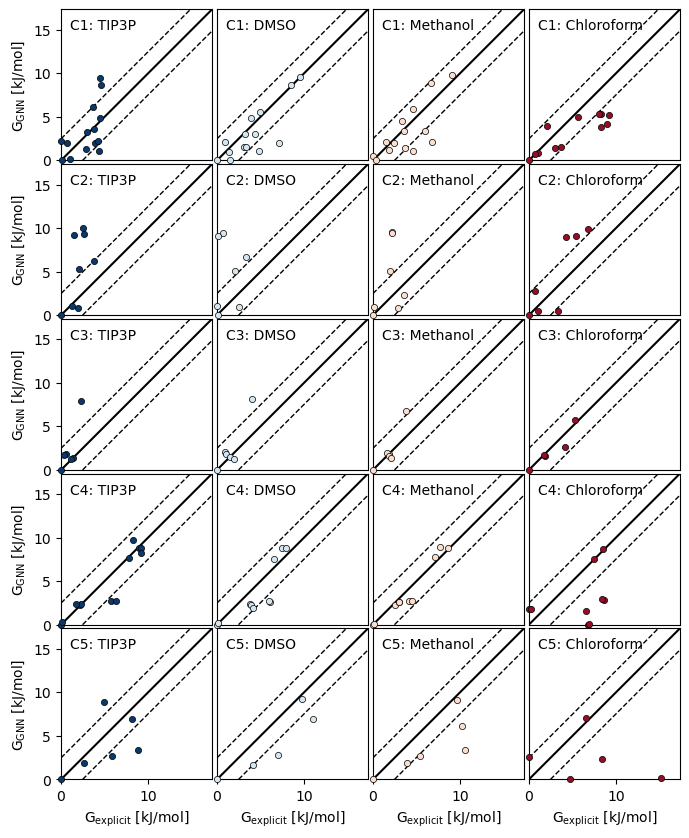

In [22]:
fig, axd = plt.subplot_mosaic([
                            ["tip3p_cor_id_%i"%id,"DMSO_cor_id_%i"%id,"Methanol_cor_id_%i"%id,"Chloroform_cor_id_%i"%id]
                             for id in range(5) if not id in [5]],figsize=(8,10))

all_exp_energies_std = []
all_all_exp_energies = []
all_pl_pre_energies = []
all_pl_exp_energies = []
all_1kbt = []
all_2kbt = []
all_confusion_matrices = DefaultDict(dict)
balanced_accuracies_C_gbneck2 = []

for id in range(5):
    for solvent in ["tip3p","DMSO","Methanol","Chloroform"]:

        full_rmsd, cluster_energies= conf_results_gbneck_dict[solvent][id]

        kbt = 2.479
        lims = 5*kbt
        lim = 7*kbt
        all_exp_energies = []
        iterator = [0.1]

        for thr in iterator:
            
            population_bin = np.bincount(np.argmin(full_rmsd,axis=0)[np.min(full_rmsd,axis=0)<thr])
            population = np.zeros(full_rmsd.shape[0])
            population[:population_bin.shape[0]] = population_bin

            # population = (full_rmsd < thr).sum(axis=1)
            pre_energies = cluster_energies-np.min(cluster_energies)
            exp_energies = in_kjmol(population,False) - np.min(in_kjmol(population,False))
            selection = (pre_energies < lims)
            exp_energies = exp_energies[selection]
            pre_energies = pre_energies[selection]

            all_exp_energies.append(exp_energies)
        
        all_exp_energies = np.stack(all_exp_energies)
        all_exp_energies[all_exp_energies == np.inf] = np.max(all_exp_energies[all_exp_energies != np.inf])
        all_all_exp_energies.append(all_exp_energies)

        exp_energies = np.nanmean(all_exp_energies,axis=0)
        exp_energies = exp_energies - np.nanmin(exp_energies)
        exp_energies_std = np.nanstd(all_exp_energies,axis=0)
        all_exp_energies_std.append(exp_energies_std)

        all_pl_pre_energies.append(pre_energies)
        all_pl_exp_energies.append(exp_energies)

        axd["%s_cor_id_%i"%(solvent,id)].scatter(exp_energies,pre_energies,zorder=3,s=20,
                                                clip_on=False,c=get_color_from_sd(solvent_dict[solvent]['dielectric']),
                                                marker='o',edgecolors='black',linewidths=0.5)
        
        ba = get_metrics(pre_energies,exp_energies,kbt)[3]

        if np.isnan(ba):
            ba = get_metrics(pre_energies,exp_energies,kbt)[2] / 2
        balanced_accuracies_C_gbneck2.append(ba)

        axd["%s_cor_id_%i"%(solvent,id)].axline([0,0],[1,1],color='black')
        axd["%s_cor_id_%i"%(solvent,id)].axline([0,kbt],[1,1+kbt],color='black',linestyle='--',linewidth=1)
        axd["%s_cor_id_%i"%(solvent,id)].axline([0,-kbt],[1,1-kbt],color='black',linestyle='--',linewidth=1)
        axd["%s_cor_id_%i"%(solvent,id)].set_xlim(0,lim)
        axd["%s_cor_id_%i"%(solvent,id)].set_ylim(0,lim)
        axd["%s_cor_id_%i"%(solvent,id)].set_xlabel('$\mathrm{G_{explicit}}$ [kJ/mol]')
        axd["%s_cor_id_%i"%(solvent,id)].set_ylabel('$\mathrm{G_{GNN}}$ [kJ/mol]')
        axd["%s_cor_id_%i"%(solvent,id)].set_aspect('equal', adjustable='box')
        coverage = (full_rmsd[selection] < 0.075).any(axis=0).mean()
        axd["%s_cor_id_%i"%(solvent,id)].text(1,15,"C%i: %s"%(id+1,solvent_dict[solvent]["nice_name"]))
        # axd["%s_cor_id_%i"%(solvent,id)].text(1,15,"$\mathrm{Err_{explicit}}$: %.1f kJ/mol"%np.nanmean(exp_energies_std),fontsize=8)
        # axd["%s_cor_id_%i"%(solvent,id)].text(1,14,"Coverage: %.2f"% coverage,fontsize=8)

        # calculate confusion matrix
        allc = []
        for confusion_lim in range(6):
            confusion_matrix = np.zeros((2,2))
            confusion_matrix[0,0] = ((exp_energies <= confusion_lim) & (pre_energies <= confusion_lim)).sum()
            confusion_matrix[0,1] = ((exp_energies < confusion_lim) & (pre_energies > confusion_lim)).sum()
            confusion_matrix[1,0] = ((exp_energies > confusion_lim) & (pre_energies < confusion_lim)).sum()
            confusion_matrix[1,1] = ((exp_energies > confusion_lim) & (pre_energies > confusion_lim)).sum()
            allc.append(confusion_matrix)
        all_confusion_matrices[id][solvent] = allc

        all_1kbt.append(np.sum(exp_energies[pre_energies < 2.479] == 0))
        all_2kbt.append(np.sum(exp_energies[pre_energies < 2.479*2] == 0))


for ax in axd.values():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

for key in axd.keys():
    if "tip3p" in key:
        axd[key].get_yaxis().set_visible(True)
    if "id_4" in key:
        axd[key].get_xaxis().set_visible(True)

plt.subplots_adjust(wspace=0.025, hspace=0.025)
fig.savefig(plot_folder + "/conformational_ensemble_correlation_gbneck_exp.pdf",bbox_inches='tight')

In [23]:
conf_results_vac_dict = DefaultDict(dict)
rest2_map = {"tip3p": "water", "Chloroform": "chloroform", "DMSO": "dmso", "Methanol": "co"}
lims = 10
for id in range(5):

    mol = Chem.MolFromSmiles(all_smiles[id])
    permutations = mol.GetSubstructMatches(mol,useChirality=True,uniquify=False)

    for gnn_solvent in ["tip3p","Chloroform","DMSO","Methanol"]:
        try:
            cluster_center_traj = mdtraj.load(f"{minimization_folder}conformational_ensemble_id_{id}/conformational_ensemble_id_{id}_vac_seed_42_cluster_center.h5")
            cluster_energies = np.load(f"{minimization_folder}conformational_ensemble_id_{id}/conformational_ensemble_id_{id}_vac_seed_42_cluster_center_free_energy.npy")
            cluster_energies = np.array(cluster_energies) - np.min(cluster_energies)
            comparison_traj = mdtraj.load(comparison_folder + "conformational_ensembl_%s_%i/ensemble-0.xtc" % (rest2_map[gnn_solvent],id),top=cluster_center_traj.top)

            cluster_center_traj = cluster_center_traj[cluster_energies<lims]
            cluster_energies = cluster_energies[cluster_energies<lims]

            full_rmsd = np.zeros((len(cluster_center_traj),comparison_traj.n_frames))
            selection_comparison = comparison_traj.top.select("element != H")
            selection_gnn = cluster_center_traj.top.select("element != H")

            for i, traj in tqdm.tqdm(enumerate(cluster_center_traj)):
                rmsds = np.zeros((len(permutations),comparison_traj.n_frames))
                for p,permutation in enumerate(permutations):
                    rmsds[p] = mdtraj.rmsd(comparison_traj,traj,atom_indices=selection_comparison,ref_atom_indices=permutation)
                full_rmsd[i] = np.min(rmsds,axis=0)

            conf_results_vac_dict[gnn_solvent][id] = (full_rmsd,cluster_energies)
        except Exception as e:
            print(e)

/localhome/kpaul/.conda/envs/GNNImplicitSolvent/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')
5it [00:00, 19.90it/s]
5it [00:00, 21.91it/s]
5it [00:00, 17.07it/s]
5it [00:00, 15.27it/s]
3it [00:00, 22.29it/s]
3it [00:00, 23.52it/s]
3it [00:00, 23.48it/s]
3it [00:00, 16.78it/s]
5it [00:00, 11.57it/s]
5it [00:00, 11.28it/s]
5it [00:00, 11.06it/s]
5it [00:00,  8.17it/s]
9it [00:00, 12.65it/s]
9it [00:00, 14.53it/s]
9it [00:00, 16.96it/s]
9it [00:00, 16.12it/s]
3it [00:00, 34.62it/s]
3it [00:00, 34.20it/s]
3it [00:00, 35.10it/s]
3it [00:00, 31.68it/s]


/tmp/ipykernel_1082213/1031731081.py:52: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axd["%s_cor_id_%i"%(solvent,id)].scatter(exp_energies,pre_energies,zorder=3,s=20,
/tmp/ipykernel_1082213/1031731081.py:52: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axd["%s_cor_id_%i"%(solvent,id)].scatter(exp_energies,pre_energies,zorder=3,s=20,
/tmp/ipykernel_1082213/1031731081.py:52: UserWarning: *c* argument looks like a single num

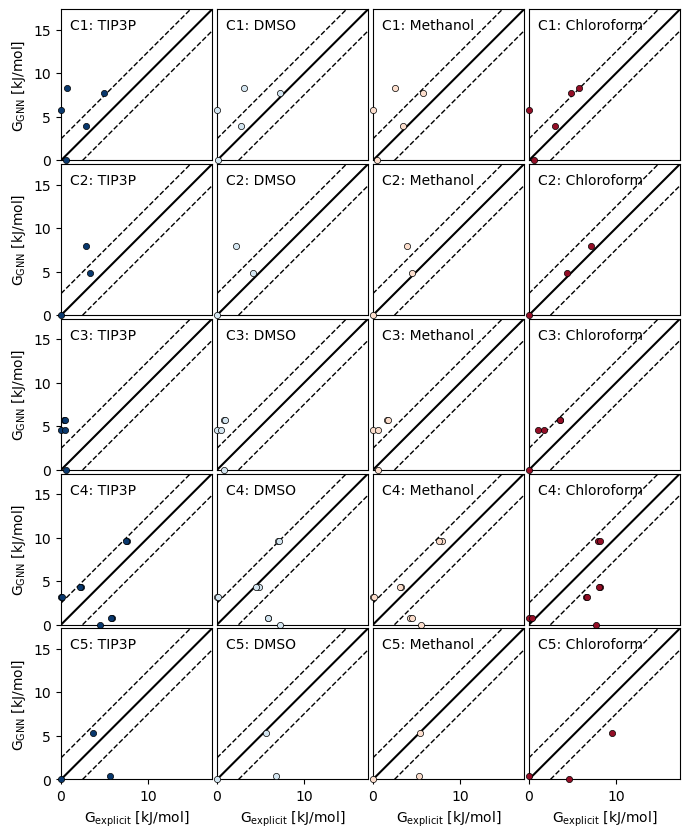

In [24]:
fig, axd = plt.subplot_mosaic([
                            ["tip3p_cor_id_%i"%id,"DMSO_cor_id_%i"%id,"Methanol_cor_id_%i"%id,"Chloroform_cor_id_%i"%id]
                             for id in range(5) if not id in [5]],figsize=(8,10))

all_exp_energies_std = []
all_all_exp_energies = []
all_pl_pre_energies = []
all_pl_exp_energies = []
all_1kbt = []
all_2kbt = []
all_confusion_matrices = DefaultDict(dict)
balanced_accuracies_C_vac = []

for id in range(5):
    for solvent in ["tip3p","DMSO","Methanol","Chloroform"]:

        full_rmsd, cluster_energies= conf_results_vac_dict[solvent][id]

        kbt = 2.479
        lims = 5*kbt
        lim = 7*kbt
        all_exp_energies = []
        iterator = [0.1]

        for thr in iterator:
            
            population_bin = np.bincount(np.argmin(full_rmsd,axis=0)[np.min(full_rmsd,axis=0)<thr])
            population = np.zeros(full_rmsd.shape[0])
            population[:population_bin.shape[0]] = population_bin

            # population = (full_rmsd < thr).sum(axis=1)
            pre_energies = cluster_energies-np.min(cluster_energies)
            exp_energies = in_kjmol(population,False) - np.min(in_kjmol(population,False))
            selection = (pre_energies < lims)
            exp_energies = exp_energies[selection]
            pre_energies = pre_energies[selection]

            all_exp_energies.append(exp_energies)
        
        all_exp_energies = np.stack(all_exp_energies)
        all_exp_energies[all_exp_energies == np.inf] = np.max(all_exp_energies[all_exp_energies != np.inf])
        all_all_exp_energies.append(all_exp_energies)

        exp_energies = np.nanmean(all_exp_energies,axis=0)
        exp_energies = exp_energies - np.nanmin(exp_energies)
        exp_energies_std = np.nanstd(all_exp_energies,axis=0)
        all_exp_energies_std.append(exp_energies_std)

        all_pl_pre_energies.append(pre_energies)
        all_pl_exp_energies.append(exp_energies)

        axd["%s_cor_id_%i"%(solvent,id)].scatter(exp_energies,pre_energies,zorder=3,s=20,
                                                clip_on=False,c=get_color_from_sd(solvent_dict[solvent]['dielectric']),
                                                marker='o',edgecolors='black',linewidths=0.5)
        ba = get_metrics(pre_energies,exp_energies,kbt)[3]

        if np.isnan(ba):
            ba = get_metrics(pre_energies,exp_energies,kbt)[2] / 2
        balanced_accuracies_C_vac.append(ba)

        axd["%s_cor_id_%i"%(solvent,id)].axline([0,0],[1,1],color='black')
        axd["%s_cor_id_%i"%(solvent,id)].axline([0,kbt],[1,1+kbt],color='black',linestyle='--',linewidth=1)
        axd["%s_cor_id_%i"%(solvent,id)].axline([0,-kbt],[1,1-kbt],color='black',linestyle='--',linewidth=1)
        axd["%s_cor_id_%i"%(solvent,id)].set_xlim(0,lim)
        axd["%s_cor_id_%i"%(solvent,id)].set_ylim(0,lim)
        axd["%s_cor_id_%i"%(solvent,id)].set_xlabel('$\mathrm{G_{explicit}}$ [kJ/mol]')
        axd["%s_cor_id_%i"%(solvent,id)].set_ylabel('$\mathrm{G_{GNN}}$ [kJ/mol]')
        axd["%s_cor_id_%i"%(solvent,id)].set_aspect('equal', adjustable='box')
        coverage = (full_rmsd[selection] < 0.075).any(axis=0).mean()
        axd["%s_cor_id_%i"%(solvent,id)].text(1,15,"C%i: %s"%(id+1,solvent_dict[solvent]["nice_name"]))
        # axd["%s_cor_id_%i"%(solvent,id)].text(1,15,"$\mathrm{Err_{explicit}}$: %.1f kJ/mol"%np.nanmean(exp_energies_std),fontsize=8)
        # axd["%s_cor_id_%i"%(solvent,id)].text(1,14,"Coverage: %.2f"% coverage,fontsize=8)

        # calculate confusion matrix
        allc = []
        for confusion_lim in range(6):
            confusion_matrix = np.zeros((2,2))
            confusion_matrix[0,0] = ((exp_energies <= confusion_lim) & (pre_energies <= confusion_lim)).sum()
            confusion_matrix[0,1] = ((exp_energies < confusion_lim) & (pre_energies > confusion_lim)).sum()
            confusion_matrix[1,0] = ((exp_energies > confusion_lim) & (pre_energies < confusion_lim)).sum()
            confusion_matrix[1,1] = ((exp_energies > confusion_lim) & (pre_energies > confusion_lim)).sum()
            allc.append(confusion_matrix)
        all_confusion_matrices[id][solvent] = allc

        all_1kbt.append(np.sum(exp_energies[pre_energies < 2.479] == 0))
        all_2kbt.append(np.sum(exp_energies[pre_energies < 2.479*2] == 0))


for ax in axd.values():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

for key in axd.keys():
    if "tip3p" in key:
        axd[key].get_yaxis().set_visible(True)
    if "id_4" in key:
        axd[key].get_xaxis().set_visible(True)

plt.subplots_adjust(wspace=0.025, hspace=0.025)
fig.savefig(plot_folder + "/conformational_ensemble_correlation_vac_exp.pdf",bbox_inches='tight')

/tmp/ipykernel_1082213/383512541.py:60: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axd["%s_cor_id_%i"%(solvent,id)].scatter(exp_energies,pre_energies,zorder=3,s=20,
/tmp/ipykernel_1082213/383512541.py:60: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axd["%s_cor_id_%i"%(solvent,id)].scatter(exp_energies,pre_energies,zorder=3,s=20,
/tmp/ipykernel_1082213/383512541.py:60: UserWarning: *c* argument looks like a single numeri

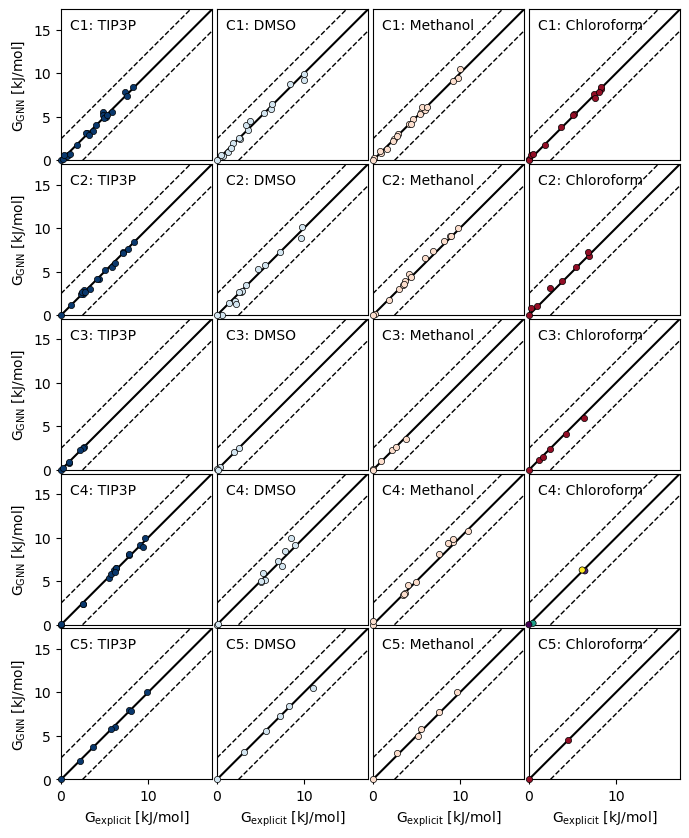

In [25]:
fig, axd = plt.subplot_mosaic([
                            ["tip3p_cor_id_%i"%id,"DMSO_cor_id_%i"%id,"Methanol_cor_id_%i"%id,"Chloroform_cor_id_%i"%id]
                             for id in range(5) if not id in [5]],figsize=(8,10))

all_exp_energies_std = []
all_all_exp_energies = []
all_pl_pre_energies = []
all_pl_exp_energies = []
all_1kbt = []
all_2kbt = []
all_confusion_matrices = DefaultDict(dict)
balanced_accuracies_C_ref = []

for id in range(5):
    for solvent in ["tip3p","DMSO","Methanol","Chloroform"]:

        full_rmsd, cluster_energies= conf_results_dict[solvent][id]

        kbt = 2.479
        lims = 5*kbt
        lim = 7*kbt
        all_exp_energies = []

        iterator = [0.1]

        for thr in iterator:
            
            full_rmsd1 = np.array_split(full_rmsd,2,axis=1)[0]
            full_rmsd2 = np.array_split(full_rmsd,2,axis=1)[-1]
            population_bin1 = np.bincount(np.argmin(full_rmsd1,axis=0)[np.min(full_rmsd1,axis=0)<thr])
            population1 = np.zeros(full_rmsd1.shape[0])
            population1[:population_bin1.shape[0]] = population_bin1
            exp_energies1 = in_kjmol(population1,False) - np.min(in_kjmol(population1,False))

            population_bin2 = np.bincount(np.argmin(full_rmsd2,axis=0)[np.min(full_rmsd2,axis=0)<thr])
            population2 = np.zeros(full_rmsd2.shape[0])
            population2[:population_bin2.shape[0]] = population_bin2
            exp_energies2 = in_kjmol(population2,False) - np.min(in_kjmol(population2,False))

            pre_energies = exp_energies1
            exp_energies = exp_energies2
            selection = (pre_energies < lims)
            exp_energies = exp_energies[selection]
            pre_energies = pre_energies[selection]

            all_exp_energies.append(exp_energies)
        
        all_exp_energies = np.stack(all_exp_energies)
        all_exp_energies[all_exp_energies == np.inf] = np.max(all_exp_energies[all_exp_energies != np.inf])
        all_all_exp_energies.append(all_exp_energies)

        exp_energies = np.nanmean(all_exp_energies,axis=0)
        exp_energies = exp_energies - np.nanmin(exp_energies)
        exp_energies_std = np.nanstd(all_exp_energies,axis=0)
        all_exp_energies_std.append(exp_energies_std)

        all_pl_pre_energies.append(pre_energies)
        all_pl_exp_energies.append(exp_energies)

        axd["%s_cor_id_%i"%(solvent,id)].scatter(exp_energies,pre_energies,zorder=3,s=20,
                                                clip_on=False,c=get_color_from_sd(solvent_dict[solvent]['dielectric']),
                                                marker='o',edgecolors='black',linewidths=0.5)
        
        balanced_accuracies_C_ref.append(get_metrics(pre_energies,exp_energies,kbt)[3])

        axd["%s_cor_id_%i"%(solvent,id)].axline([0,0],[1,1],color='black')
        axd["%s_cor_id_%i"%(solvent,id)].axline([0,kbt],[1,1+kbt],color='black',linestyle='--',linewidth=1)
        axd["%s_cor_id_%i"%(solvent,id)].axline([0,-kbt],[1,1-kbt],color='black',linestyle='--',linewidth=1)
        axd["%s_cor_id_%i"%(solvent,id)].set_xlim(0,lim)
        axd["%s_cor_id_%i"%(solvent,id)].set_ylim(0,lim)
        axd["%s_cor_id_%i"%(solvent,id)].set_xlabel('$\mathrm{G_{explicit}}$ [kJ/mol]')
        axd["%s_cor_id_%i"%(solvent,id)].set_ylabel('$\mathrm{G_{GNN}}$ [kJ/mol]')
        axd["%s_cor_id_%i"%(solvent,id)].set_aspect('equal', adjustable='box')
        coverage = (full_rmsd[selection] < 0.075).any(axis=0).mean()
        axd["%s_cor_id_%i"%(solvent,id)].text(1,15,"C%i: %s"%(id+1,solvent_dict[solvent]["nice_name"]))
        # axd["%s_cor_id_%i"%(solvent,id)].text(1,15,"$\mathrm{Err_{explicit}}$: %.1f kJ/mol"%np.nanmean(exp_energies_std),fontsize=8)
        # axd["%s_cor_id_%i"%(solvent,id)].text(1,14,"Coverage: %.2f"% coverage,fontsize=8)

        # calculate confusion matrix
        allc = []
        for confusion_lim in range(6):
            confusion_matrix = np.zeros((2,2))
            confusion_matrix[0,0] = ((exp_energies <= confusion_lim) & (pre_energies <= confusion_lim)).sum()
            confusion_matrix[0,1] = ((exp_energies < confusion_lim) & (pre_energies > confusion_lim)).sum()
            confusion_matrix[1,0] = ((exp_energies > confusion_lim) & (pre_energies < confusion_lim)).sum()
            confusion_matrix[1,1] = ((exp_energies > confusion_lim) & (pre_energies > confusion_lim)).sum()
            allc.append(confusion_matrix)
        all_confusion_matrices[id][solvent] = allc

        all_1kbt.append(np.sum(exp_energies[pre_energies < 2.479] == 0))
        all_2kbt.append(np.sum(exp_energies[pre_energies < 2.479*2] == 0))


for ax in axd.values():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

for key in axd.keys():
    if "tip3p" in key:
        axd[key].get_yaxis().set_visible(True)
    if "id_4" in key:
        axd[key].get_xaxis().set_visible(True)

plt.subplots_adjust(wspace=0.025, hspace=0.025)
fig.savefig(plot_folder + "/conformational_ensemble_correlation_exp_exp.pdf",bbox_inches='tight')

In [26]:
from scipy.stats import wilcoxon

In [27]:
wilcoxon(balanced_accuracies_C_ref,balanced_accuracies_C),wilcoxon(balanced_accuracies_C,balanced_accuracies_C_gbneck2),wilcoxon(balanced_accuracies_C,balanced_accuracies_C_vac),wilcoxon(balanced_accuracies_C_gbneck2,balanced_accuracies_C_vac)

/localhome/kpaul/.conda/envs/GNNImplicitSolvent/lib/python3.10/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


(WilcoxonResult(statistic=3.0, pvalue=0.0011735028418137538),
 WilcoxonResult(statistic=50.5, pvalue=0.12721752948827642),
 WilcoxonResult(statistic=30.0, pvalue=0.008834490074606871),
 WilcoxonResult(statistic=62.5, pvalue=0.19078235123834453))

# Set P

In [ ]:
comparison_folder = "/fileserver/pine/pine8/kpaul/multi_solvent_pub/data/REST2/REST2_pub/"
minimization_folder = "/fileserver/pine/pine8/kpaul/multi_solvent_pub/data/Minimizations/platinum_results_51200/"
platinum_smiles = np.loadtxt("../Simulation/simulation_smiles/platinum_diverse_selection.txt",dtype=str,comments=None)

In [29]:
import pickle
pr_folder = "/fileserver/pine/pine8/kpaul/multi_solvent_pub/data/Minimizations/processed_results/"
conf_results_dict = pickle.load(open(pr_folder+"platinum_conf_results_dict.pkl","rb"))

In [30]:
kbt = 2.479

In [31]:
# conf_results_dict = DefaultDict(dict)
rest2_map = {"tip3p": "water", "Chloroform": "chloroform", "DMSO": "dmso", "Methanol": "co"}
lims = 5*kbt
for id in range(10):

    mol = Chem.MolFromSmiles(platinum_smiles[id])
    permutations = mol.GetSubstructMatches(mol,useChirality=True,uniquify=False)

    for gnn_solvent in ["tip3p","Chloroform","DMSO","Methanol"]:
        if gnn_solvent in conf_results_dict.keys():
            if id in conf_results_dict[gnn_solvent].keys():
                continue
        try:
            cluster_center_traj = mdtraj.load(f"{minimization_folder}platinum_diverse_id_{id}/platinum_diverse_id_{id}_{gnn_solvent}_seed_42_cluster_center.h5")
            cluster_energies = np.load(f"{minimization_folder}platinum_diverse_id_{id}/platinum_diverse_id_{id}_{gnn_solvent}_seed_42_cluster_center_free_energy.npy")
            cluster_energies = np.array(cluster_energies) - np.nanmin(cluster_energies)
            comparison_traj = mdtraj.load(comparison_folder + "platinum_diverse_selection_ET1_%s_%i/ensemble-0.xtc" % (rest2_map[gnn_solvent],id),top=cluster_center_traj.top)

            ene = np.array(cluster_energies)
            selection = (ene < np.nanmedian(ene)+4*np.nanstd(ene)) & (ene > np.nanmedian(ene)-4*np.nanstd(ene))
            cluster_center_traj = cluster_center_traj[selection]
            cluster_energies = cluster_energies[selection]
            cluster_energies = cluster_energies - np.nanmin(cluster_energies)
            cluster_center_traj = cluster_center_traj[cluster_energies<lims]
            cluster_energies = cluster_energies[cluster_energies<lims]


            if id == 9:
                dh_gnn = get_dihedrals_by_name(cluster_center_traj,*("C8 C7 C6 C4".split(" ")))
                selection = np.argwhere((dh_gnn < 0).flatten()).flatten()
                cluster_center_traj = cluster_center_traj[selection]
                cluster_energies = cluster_energies[selection]

            full_rmsd = np.zeros((len(cluster_center_traj),comparison_traj.n_frames))
            selection_comparison = comparison_traj.top.select("element != H")
            selection_gnn = cluster_center_traj.top.select("element != H")

            for i, traj in tqdm.tqdm(enumerate(cluster_center_traj)):
                rmsds = np.zeros((len(permutations),comparison_traj.n_frames))
                for p,permutation in enumerate(permutations):
                    rmsds[p] = mdtraj.rmsd(comparison_traj,traj,atom_indices=selection_comparison,ref_atom_indices=permutation)
                full_rmsd[i] = np.min(rmsds,axis=0)

            conf_results_dict[gnn_solvent][id] = (full_rmsd,cluster_energies)
        except Exception as e:
            print(e)

In [32]:
### Save conf_results_dict as pickle
import pickle
pr_folder = "/fileserver/pine/pine8/kpaul/multi_solvent_pub/data/Minimizations/processed_results/"
pickle.dump(conf_results_dict,open(pr_folder+"platinum_conf_results_dict.pkl","wb"))

/tmp/ipykernel_1082213/3461582015.py:58: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axd["%s_cor_id_%i"%(solvent,id)].scatter(exp_energies,pre_energies,zorder=3,s=20,
/tmp/ipykernel_1082213/3461582015.py:58: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axd["%s_cor_id_%i"%(solvent,id)].scatter(exp_energies,pre_energies,zorder=3,s=20,
/tmp/ipykernel_1082213/3461582015.py:58: UserWarning: *c* argument looks like a single num

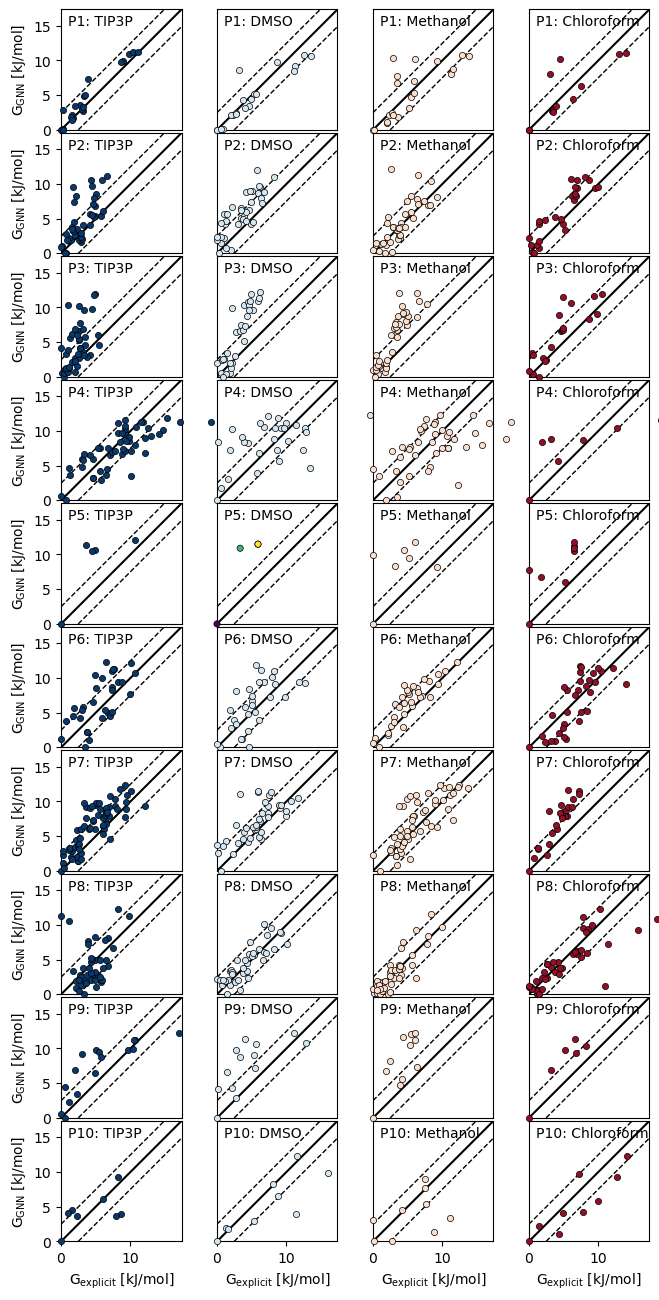

In [33]:
fig, axd = plt.subplot_mosaic([
                            ["tip3p_cor_id_%i"%id,"DMSO_cor_id_%i"%id,"Methanol_cor_id_%i"%id,"Chloroform_cor_id_%i"%id]
                             for id in range(10)],figsize=(8,16))

all_exp_energies_std = []
all_all_exp_energies = []
all_pl_pre_energies = []
all_pl_exp_energies = []
all_1kbt = []
all_2kbt = []
all_confusion_matrices = DefaultDict(dict)
balanced_accuracies = []
median_errors = []
all_metrics = []

for id in range(10):
    for solvent in ["tip3p","DMSO","Methanol","Chloroform"]:

        try:
            full_rmsd, cluster_energies = conf_results_dict[solvent][id]
        except:
            continue
        kbt = 2.479
        lims = 5*kbt
        lim = 7*kbt
        all_exp_energies = []

        iterator = np.arange(0.04,0.06,0.005)
        iterator = [0.1]

        for thr in iterator:
            
            population_bin = np.bincount(np.argmin(full_rmsd,axis=0)[np.min(full_rmsd,axis=0)<thr])
            population = np.zeros(full_rmsd.shape[0])
            population[:population_bin.shape[0]] = population_bin

            # population = (full_rmsd < thr).sum(axis=1)
            pre_energies = cluster_energies-np.min(cluster_energies)
            exp_energies = in_kjmol(population,False) - np.min(in_kjmol(population,False))
            selection = (pre_energies < lims)
            exp_energies = exp_energies[selection]
            pre_energies = pre_energies[selection]

            all_exp_energies.append(exp_energies)
        
        all_exp_energies = np.stack(all_exp_energies)
        all_exp_energies[all_exp_energies == np.inf] = np.max(all_exp_energies[all_exp_energies != np.inf])
        all_all_exp_energies.append(all_exp_energies)

        exp_energies = np.nanmean(all_exp_energies,axis=0)
        exp_energies = exp_energies - np.nanmin(exp_energies)
        exp_energies_std = np.nanstd(all_exp_energies,axis=0)
        all_exp_energies_std.append(exp_energies_std)

        all_pl_pre_energies.append(pre_energies)
        all_pl_exp_energies.append(exp_energies)

        axd["%s_cor_id_%i"%(solvent,id)].scatter(exp_energies,pre_energies,zorder=3,s=20,
                                                clip_on=False,c=get_color_from_sd(solvent_dict[solvent]['dielectric']),
                                                marker='o',edgecolors='black',linewidths=0.5)
        axd["%s_cor_id_%i"%(solvent,id)].axline([0,0],[1,1],color='black')
        axd["%s_cor_id_%i"%(solvent,id)].axline([0,kbt],[1,1+kbt],color='black',linestyle='--',linewidth=1)
        axd["%s_cor_id_%i"%(solvent,id)].axline([0,-kbt],[1,1-kbt],color='black',linestyle='--',linewidth=1)
        axd["%s_cor_id_%i"%(solvent,id)].set_xlim(0,lim)
        axd["%s_cor_id_%i"%(solvent,id)].set_ylim(0,lim)
        axd["%s_cor_id_%i"%(solvent,id)].set_xlabel('$\mathrm{G_{explicit}}$ [kJ/mol]')
        axd["%s_cor_id_%i"%(solvent,id)].set_ylabel('$\mathrm{G_{GNN}}$ [kJ/mol]')
        axd["%s_cor_id_%i"%(solvent,id)].set_aspect('equal', adjustable='box')
        coverage = (full_rmsd[selection] < 0.2).any(axis=0).mean()
        axd["%s_cor_id_%i"%(solvent,id)].text(1,15,"P%i: %s"%(id+1,solvent_dict[solvent]["nice_name"]))
        # axd["%s_cor_id_%i"%(solvent,id)].text(1,15,"$\mathrm{Err_{explicit}}$: %.1f kJ/mol"%np.nanmean(exp_energies_std),fontsize=8)
        # axd["%s_cor_id_%i"%(solvent,id)].text(1,14,"Coverage: %.2f"% coverage,fontsize=8)

        # calculate confusion matrix
        allc = []
        for confusion_lim in range(6):
            confusion_matrix = np.zeros((2,2))
            confusion_matrix[0,0] = ((exp_energies <= confusion_lim) & (pre_energies <= confusion_lim)).sum()
            confusion_matrix[0,1] = ((exp_energies < confusion_lim) & (pre_energies > confusion_lim)).sum()
            confusion_matrix[1,0] = ((exp_energies > confusion_lim) & (pre_energies < confusion_lim)).sum()
            confusion_matrix[1,1] = ((exp_energies > confusion_lim) & (pre_energies > confusion_lim)).sum()
            allc.append(confusion_matrix)
        all_confusion_matrices[id][solvent] = allc
        balanced_accuracies.append(get_metrics(exp_energies,pre_energies,kbt)[3])
        all_metrics.append(get_metrics(exp_energies,pre_energies,kbt))

        all_1kbt.append(np.sum(exp_energies[pre_energies < 2.479] == 0))
        all_2kbt.append(np.sum(exp_energies[pre_energies < 2.479*2] == 0))
        median_errors.append(np.median(np.abs(exp_energies-pre_energies)))

for ax in axd.values():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

for key in axd.keys():
    if "tip3p" in key:
        axd[key].get_yaxis().set_visible(True)
    if "id_9" in key:
        axd[key].get_xaxis().set_visible(True)

plt.subplots_adjust(wspace=0.025, hspace=0.025)
fig.savefig(plot_folder + "/platinum_diverse_correlation_gnn_exp.pdf",bbox_inches='tight')

In [34]:
conf_results_gbneck_dict = pickle.load(open(pr_folder+"platinum_conf_results_gbneck_dict.pkl","rb"))

In [35]:
rest2_map = {"tip3p": "water", "Chloroform": "chloroform", "DMSO": "dmso", "Methanol": "co"}
lims = 5*kbt
for id in range(10):

    mol = Chem.MolFromSmiles(platinum_smiles[id])
    permutations = mol.GetSubstructMatches(mol,useChirality=True,uniquify=False)

    for gnn_solvent in ["tip3p","Chloroform","DMSO","Methanol"]:
        if gnn_solvent in conf_results_gbneck_dict.keys():
            if id in conf_results_gbneck_dict[gnn_solvent].keys():
                continue
        try:

            cluster_center_traj = mdtraj.load(f"{minimization_folder}platinum_diverse_id_{id}/platinum_diverse_id_{id}_gbneck2_{gnn_solvent}_seed_42_cluster_center.h5")
            cluster_energies = np.load(f"{minimization_folder}platinum_diverse_id_{id}/platinum_diverse_id_{id}_gbneck2_{gnn_solvent}_seed_42_cluster_center_free_energy.npy")
            cluster_energies = np.array(cluster_energies) - np.nanmin(cluster_energies)
            comparison_traj = mdtraj.load(comparison_folder + "platinum_diverse_selection_ET1_%s_%i/ensemble-0.xtc" % (rest2_map[gnn_solvent],id),top=cluster_center_traj.top)

            cluster_center_traj = cluster_center_traj[cluster_energies<lims]
            cluster_energies = cluster_energies[cluster_energies<lims]

            if id == 9:
                dh_gnn = get_dihedrals_by_name(cluster_center_traj,*("C8 C7 C6 C4".split(" ")))
                selection = np.argwhere((dh_gnn < 0).flatten()).flatten()
                cluster_center_traj = cluster_center_traj[selection]
                cluster_energies = cluster_energies[selection]

            full_rmsd = np.zeros((len(cluster_center_traj),comparison_traj.n_frames))
            selection_comparison = comparison_traj.top.select("element != H")
            selection_gnn = cluster_center_traj.top.select("element != H")

            for i, traj in tqdm.tqdm(enumerate(cluster_center_traj)):
                rmsds = np.zeros((len(permutations),comparison_traj.n_frames))
                for p,permutation in enumerate(permutations):
                    rmsds[p] = mdtraj.rmsd(comparison_traj,traj,atom_indices=selection_comparison,ref_atom_indices=permutation)
                full_rmsd[i] = np.min(rmsds,axis=0)

            conf_results_gbneck_dict[gnn_solvent][id] = (full_rmsd,cluster_energies)
        except Exception as e:
            print(e)

In [36]:
pickle.dump(conf_results_gbneck_dict,open(pr_folder+"platinum_conf_results_gbneck_dict.pkl","wb"))

/tmp/ipykernel_1082213/4093816038.py:60: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axd["%s_cor_id_%i"%(solvent,id)].scatter(exp_energies,pre_energies,zorder=3,s=20,
/tmp/ipykernel_1082213/4093816038.py:60: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axd["%s_cor_id_%i"%(solvent,id)].scatter(exp_energies,pre_energies,zorder=3,s=20,
/tmp/ipykernel_1082213/4093816038.py:60: UserWarning: *c* argument looks like a single num

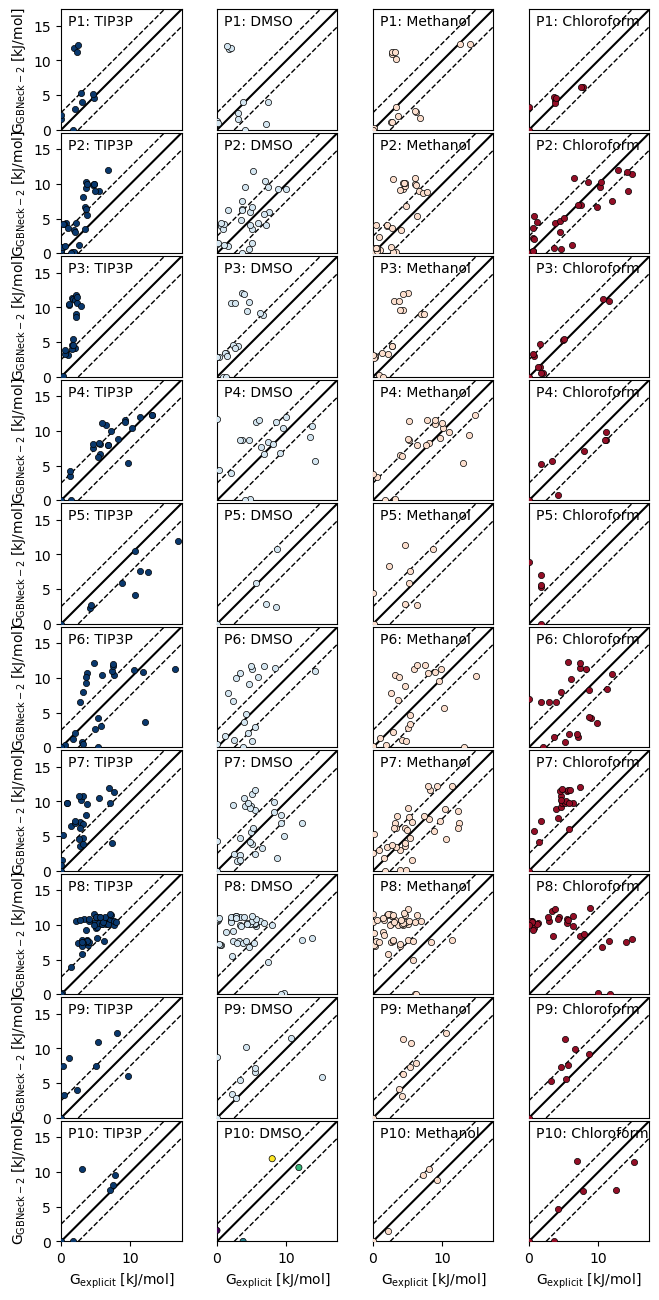

In [37]:
fig, axd = plt.subplot_mosaic([
                            ["tip3p_cor_id_%i"%id,"DMSO_cor_id_%i"%id,"Methanol_cor_id_%i"%id,"Chloroform_cor_id_%i"%id]
                             for id in range(10)],figsize=(8,16))

all_exp_energies_std = []
all_all_exp_energies = []
all_pl_pre_energies = []
all_pl_exp_energies = []
all_1kbt = []
all_2kbt = []
all_confusion_matrices = DefaultDict(dict)
balanced_accuracies_gbneck2 = []
median_errors_gbneck2 = []
all_metrics_gbneck2 = []

for id in range(10):

    for solvent in ["tip3p","DMSO","Methanol","Chloroform"]:
        
        try:
            full_rmsd, cluster_energies = conf_results_gbneck_dict[solvent][id]
        except:
            continue

        kbt = 2.479
        lims = 5*kbt
        lim = 7*kbt
        all_exp_energies = []

        iterator = np.arange(0.04,0.06,0.005)
        iterator = [0.1]

        for thr in iterator:
            
            population_bin = np.bincount(np.argmin(full_rmsd,axis=0)[np.min(full_rmsd,axis=0)<thr])
            population = np.zeros(full_rmsd.shape[0])
            population[:population_bin.shape[0]] = population_bin

            # population = (full_rmsd < thr).sum(axis=1)
            pre_energies = cluster_energies-np.min(cluster_energies)
            exp_energies = in_kjmol(population,False) - np.min(in_kjmol(population,False))
            selection = (pre_energies < lims)
            exp_energies = exp_energies[selection]
            pre_energies = pre_energies[selection]

            all_exp_energies.append(exp_energies)
        
        all_exp_energies = np.stack(all_exp_energies)
        all_exp_energies[all_exp_energies == np.inf] = np.max(all_exp_energies[all_exp_energies != np.inf])
        all_all_exp_energies.append(all_exp_energies)

        exp_energies = np.nanmean(all_exp_energies,axis=0)
        exp_energies = exp_energies - np.nanmin(exp_energies)
        exp_energies_std = np.nanstd(all_exp_energies,axis=0)
        all_exp_energies_std.append(exp_energies_std)

        all_pl_pre_energies.append(pre_energies)
        all_pl_exp_energies.append(exp_energies)

        axd["%s_cor_id_%i"%(solvent,id)].scatter(exp_energies,pre_energies,zorder=3,s=20,
                                                clip_on=True,c=get_color_from_sd(solvent_dict[solvent]['dielectric']),
                                                marker='o',edgecolors='black',linewidths=0.5)
        axd["%s_cor_id_%i"%(solvent,id)].axline([0,0],[1,1],color='black')
        axd["%s_cor_id_%i"%(solvent,id)].axline([0,kbt],[1,1+kbt],color='black',linestyle='--',linewidth=1)
        axd["%s_cor_id_%i"%(solvent,id)].axline([0,-kbt],[1,1-kbt],color='black',linestyle='--',linewidth=1)
        axd["%s_cor_id_%i"%(solvent,id)].set_xlim(0,lim)
        axd["%s_cor_id_%i"%(solvent,id)].set_ylim(0,lim)
        axd["%s_cor_id_%i"%(solvent,id)].set_xlabel('$\mathrm{G_{explicit}}$ [kJ/mol]')
        axd["%s_cor_id_%i"%(solvent,id)].set_ylabel('$\mathrm{G_{GBNeck-2}}$ [kJ/mol]')
        axd["%s_cor_id_%i"%(solvent,id)].set_aspect('equal', adjustable='box')
        coverage = (full_rmsd[selection] < 0.2).any(axis=0).mean()
        axd["%s_cor_id_%i"%(solvent,id)].text(1,15,"P%i: %s"%(id+1,solvent_dict[solvent]["nice_name"]))
        # axd["%s_cor_id_%i"%(solvent,id)].text(1,15,"$\mathrm{Err_{explicit}}$: %.1f kJ/mol"%np.nanmean(exp_energies_std),fontsize=8)
        # axd["%s_cor_id_%i"%(solvent,id)].text(1,14,"Coverage: %.2f"% coverage,fontsize=8)

        # calculate confusion matrix
        allc = []
        for confusion_lim in range(6):
            confusion_matrix = np.zeros((2,2))
            confusion_matrix[0,0] = ((exp_energies <= confusion_lim) & (pre_energies <= confusion_lim)).sum()
            confusion_matrix[0,1] = ((exp_energies < confusion_lim) & (pre_energies > confusion_lim)).sum()
            confusion_matrix[1,0] = ((exp_energies > confusion_lim) & (pre_energies < confusion_lim)).sum()
            confusion_matrix[1,1] = ((exp_energies > confusion_lim) & (pre_energies > confusion_lim)).sum()
            allc.append(confusion_matrix)
        all_confusion_matrices[id][solvent] = allc
        balanced_accuracies_gbneck2.append(get_metrics(exp_energies,pre_energies,kbt)[3])
        all_metrics_gbneck2.append(get_metrics(exp_energies,pre_energies,kbt))
        median_errors_gbneck2.append(np.nanmedian(np.abs(exp_energies-pre_energies)))

        all_1kbt.append(np.sum(exp_energies[pre_energies < 2.479] == 0))
        all_2kbt.append(np.sum(exp_energies[pre_energies < 2.479*2] == 0))

for ax in axd.values():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


for key in axd.keys():
    if "tip3p" in key:
        axd[key].get_yaxis().set_visible(True)
    if "id_9" in key:
        axd[key].get_xaxis().set_visible(True)

plt.subplots_adjust(wspace=0.025, hspace=0.025)
fig.savefig(plot_folder + "/platinum_diverse_correlation_gbneck_exp.pdf",bbox_inches='tight')

### Get vacuum

In [38]:
conf_results_vac_dict = pickle.load(open(pr_folder+"platinum_conf_results_vac_dict.pkl","rb"))

In [39]:
rest2_map = {"tip3p": "water", "Chloroform": "chloroform", "DMSO": "dmso", "Methanol": "co"}
lims = 5*kbt
for id in range(10):

    mol = Chem.MolFromSmiles(platinum_smiles[id])
    permutations = mol.GetSubstructMatches(mol,useChirality=True,uniquify=False)

    for gnn_solvent in ["tip3p","Chloroform","DMSO","Methanol"]:
        if gnn_solvent in conf_results_gbneck_dict.keys():
            if id in conf_results_vac_dict[gnn_solvent].keys():
                continue
        try:

            cluster_center_traj = mdtraj.load(f"{minimization_folder}platinum_diverse_id_{id}/platinum_diverse_id_{id}_vac_seed_42_cluster_center.h5")
            cluster_energies = np.load(f"{minimization_folder}platinum_diverse_id_{id}/platinum_diverse_id_{id}_vac_seed_42_cluster_center_free_energy.npy")
            cluster_energies = np.array(cluster_energies) - np.nanmin(cluster_energies)
            comparison_traj = mdtraj.load(comparison_folder + "platinum_diverse_selection_ET1_%s_%i/ensemble-0.xtc" % (rest2_map[gnn_solvent],id),top=cluster_center_traj.top)

            cluster_center_traj = cluster_center_traj[cluster_energies<lims]
            cluster_energies = cluster_energies[cluster_energies<lims]

            if id == 9:
                dh_gnn = get_dihedrals_by_name(cluster_center_traj,*("C8 C7 C6 C4".split(" ")))
                selection = np.argwhere((dh_gnn < 0).flatten()).flatten()
                cluster_center_traj = cluster_center_traj[selection]
                cluster_energies = cluster_energies[selection]

            full_rmsd = np.zeros((len(cluster_center_traj),comparison_traj.n_frames))
            selection_comparison = comparison_traj.top.select("element != H")
            selection_gnn = cluster_center_traj.top.select("element != H")

            for i, traj in tqdm.tqdm(enumerate(cluster_center_traj)):
                rmsds = np.zeros((len(permutations),comparison_traj.n_frames))
                for p,permutation in enumerate(permutations):
                    rmsds[p] = mdtraj.rmsd(comparison_traj,traj,atom_indices=selection_comparison,ref_atom_indices=permutation)
                full_rmsd[i] = np.min(rmsds,axis=0)

            conf_results_vac_dict[gnn_solvent][id] = (full_rmsd,cluster_energies)
        except Exception as e:
            print(e)

In [40]:
pickle.dump(conf_results_vac_dict,open(pr_folder+"platinum_conf_results_vac_dict.pkl","wb"))

/tmp/ipykernel_1082213/2991484343.py:60: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axd["%s_cor_id_%i"%(solvent,id)].scatter(exp_energies,pre_energies,zorder=3,s=20,
/tmp/ipykernel_1082213/2991484343.py:60: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axd["%s_cor_id_%i"%(solvent,id)].scatter(exp_energies,pre_energies,zorder=3,s=20,
/tmp/ipykernel_1082213/2991484343.py:60: UserWarning: *c* argument looks like a single num

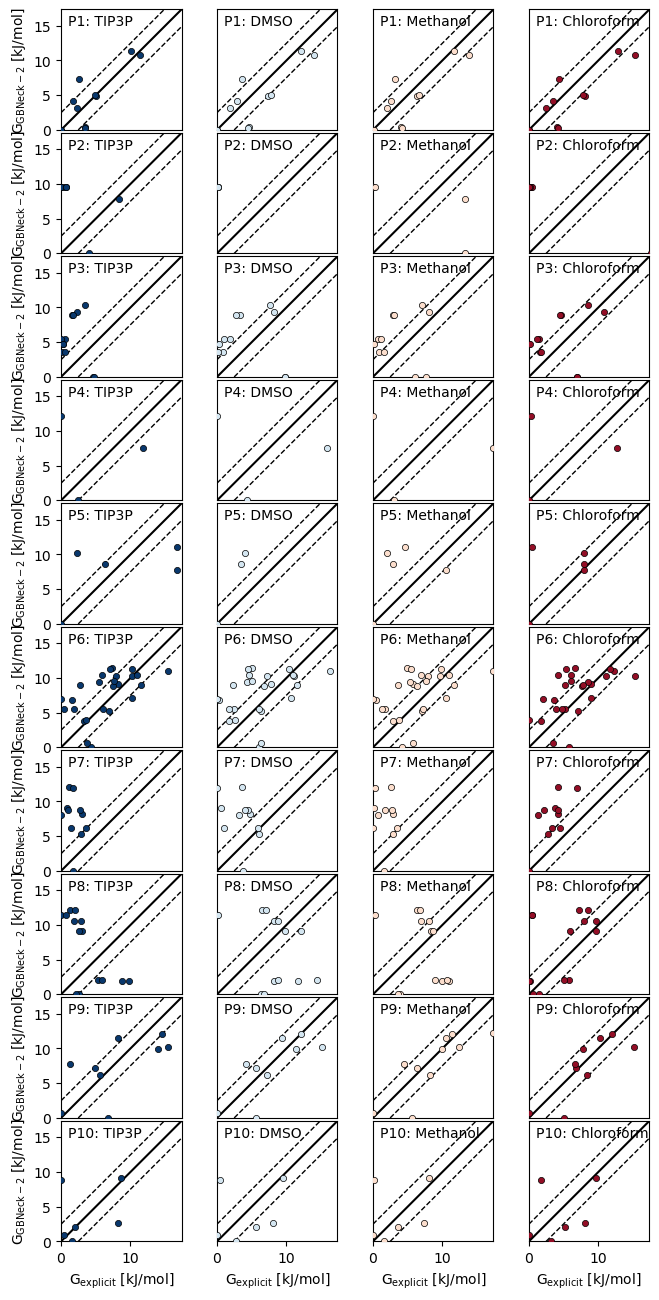

In [41]:
ig, axd = plt.subplot_mosaic([
                            ["tip3p_cor_id_%i"%id,"DMSO_cor_id_%i"%id,"Methanol_cor_id_%i"%id,"Chloroform_cor_id_%i"%id]
                             for id in range(10)],figsize=(8,16))

all_exp_energies_std = []
all_all_exp_energies = []
all_pl_pre_energies = []
all_pl_exp_energies = []
all_1kbt = []
all_2kbt = []
all_confusion_matrices = DefaultDict(dict)
balanced_accuracies_vac = []
median_errors_vac = []
all_metrics_vac = []

for id in range(10):

    for solvent in ["tip3p","DMSO","Methanol","Chloroform"]:
        
        try:
            full_rmsd, cluster_energies = conf_results_vac_dict[solvent][id]
        except:
            continue

        kbt = 2.479
        lims = 5*kbt
        lim = 7*kbt
        all_exp_energies = []

        iterator = np.arange(0.04,0.06,0.005)
        iterator = [0.1]

        for thr in iterator:
            
            population_bin = np.bincount(np.argmin(full_rmsd,axis=0)[np.min(full_rmsd,axis=0)<thr])
            population = np.zeros(full_rmsd.shape[0])
            population[:population_bin.shape[0]] = population_bin

            # population = (full_rmsd < thr).sum(axis=1)
            pre_energies = cluster_energies-np.min(cluster_energies)
            exp_energies = in_kjmol(population,False) - np.min(in_kjmol(population,False))
            selection = (pre_energies < lims)
            exp_energies = exp_energies[selection]
            pre_energies = pre_energies[selection]

            all_exp_energies.append(exp_energies)
        
        all_exp_energies = np.stack(all_exp_energies)
        all_exp_energies[all_exp_energies == np.inf] = np.max(all_exp_energies[all_exp_energies != np.inf])
        all_all_exp_energies.append(all_exp_energies)

        exp_energies = np.nanmean(all_exp_energies,axis=0)
        exp_energies = exp_energies - np.nanmin(exp_energies)
        exp_energies_std = np.nanstd(all_exp_energies,axis=0)
        all_exp_energies_std.append(exp_energies_std)

        all_pl_pre_energies.append(pre_energies)
        all_pl_exp_energies.append(exp_energies)

        axd["%s_cor_id_%i"%(solvent,id)].scatter(exp_energies,pre_energies,zorder=3,s=20,
                                                clip_on=True,c=get_color_from_sd(solvent_dict[solvent]['dielectric']),
                                                marker='o',edgecolors='black',linewidths=0.5)
        axd["%s_cor_id_%i"%(solvent,id)].axline([0,0],[1,1],color='black')
        axd["%s_cor_id_%i"%(solvent,id)].axline([0,kbt],[1,1+kbt],color='black',linestyle='--',linewidth=1)
        axd["%s_cor_id_%i"%(solvent,id)].axline([0,-kbt],[1,1-kbt],color='black',linestyle='--',linewidth=1)
        axd["%s_cor_id_%i"%(solvent,id)].set_xlim(0,lim)
        axd["%s_cor_id_%i"%(solvent,id)].set_ylim(0,lim)
        axd["%s_cor_id_%i"%(solvent,id)].set_xlabel('$\mathrm{G_{explicit}}$ [kJ/mol]')
        axd["%s_cor_id_%i"%(solvent,id)].set_ylabel('$\mathrm{G_{GBNeck-2}}$ [kJ/mol]')
        axd["%s_cor_id_%i"%(solvent,id)].set_aspect('equal', adjustable='box')
        coverage = (full_rmsd[selection] < 0.2).any(axis=0).mean()
        axd["%s_cor_id_%i"%(solvent,id)].text(1,15,"P%i: %s"%(id+1,solvent_dict[solvent]["nice_name"]))
        # axd["%s_cor_id_%i"%(solvent,id)].text(1,15,"$\mathrm{Err_{explicit}}$: %.1f kJ/mol"%np.nanmean(exp_energies_std),fontsize=8)
        # axd["%s_cor_id_%i"%(solvent,id)].text(1,14,"Coverage: %.2f"% coverage,fontsize=8)

        # calculate confusion matrix
        allc = []
        for confusion_lim in range(6):
            confusion_matrix = np.zeros((2,2))
            confusion_matrix[0,0] = ((exp_energies <= confusion_lim) & (pre_energies <= confusion_lim)).sum()
            confusion_matrix[0,1] = ((exp_energies < confusion_lim) & (pre_energies > confusion_lim)).sum()
            confusion_matrix[1,0] = ((exp_energies > confusion_lim) & (pre_energies < confusion_lim)).sum()
            confusion_matrix[1,1] = ((exp_energies > confusion_lim) & (pre_energies > confusion_lim)).sum()
            allc.append(confusion_matrix)
        all_confusion_matrices[id][solvent] = allc
        balanced_accuracies_vac.append(get_metrics(exp_energies,pre_energies,kbt)[3])
        all_metrics_vac.append(get_metrics(exp_energies,pre_energies,kbt))
        median_errors_vac.append(np.nanmedian(np.abs(exp_energies-pre_energies)))

        all_1kbt.append(np.sum(exp_energies[pre_energies < 2.479] == 0))
        all_2kbt.append(np.sum(exp_energies[pre_energies < 2.479*2] == 0))

for ax in axd.values():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


for key in axd.keys():
    if "tip3p" in key:
        axd[key].get_yaxis().set_visible(True)
    if "id_9" in key:
        axd[key].get_xaxis().set_visible(True)

plt.subplots_adjust(wspace=0.025, hspace=0.025)
fig.savefig(plot_folder + "/platinum_diverse_correlation_vac_exp.pdf",bbox_inches='tight')

## Get reference for explicit simulation

/tmp/ipykernel_1082213/933592010.py:66: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axd["%s_cor_id_%i"%(solvent,id)].scatter(exp_energies,pre_energies,zorder=3,s=20,
/tmp/ipykernel_1082213/933592010.py:66: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axd["%s_cor_id_%i"%(solvent,id)].scatter(exp_energies,pre_energies,zorder=3,s=20,
/tmp/ipykernel_1082213/933592010.py:66: UserWarning: *c* argument looks like a single numeri

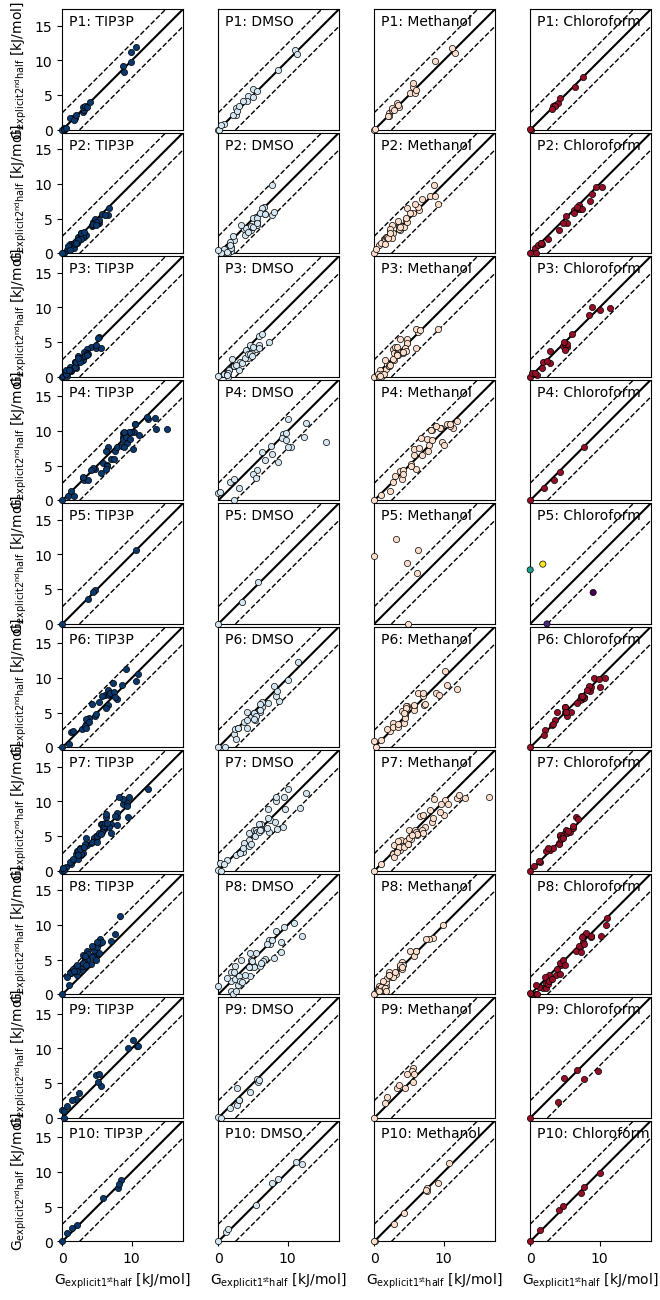

In [42]:
fig, axd = plt.subplot_mosaic([
                            ["tip3p_cor_id_%i"%id,"DMSO_cor_id_%i"%id,"Methanol_cor_id_%i"%id,"Chloroform_cor_id_%i"%id]
                             for id in range(10)],figsize=(8,16))

all_exp_energies_std = []
all_all_exp_energies = []
all_pl_pre_energies = []
all_pl_exp_energies = []
all_1kbt = []
all_2kbt = []
all_confusion_matrices_ref = DefaultDict(dict)
balanced_accuracies_ref = []
median_errors = []
all_metrics_ref = []

for id in range(10):
    for solvent in ["tip3p","DMSO","Methanol","Chloroform"]:

        try:
            full_rmsd, cluster_energies = conf_results_dict[solvent][id]
        except:
            continue
        kbt = 2.479
        lims = 5*kbt
        lim = 7*kbt
        all_exp_energies = []

        iterator = np.arange(0.04,0.06,0.005)
        iterator = [0.1]

        for thr in iterator:
            
            full_rmsd1 = np.array_split(full_rmsd,2,axis=1)[0]
            full_rmsd2 = np.array_split(full_rmsd,2,axis=1)[-1]

            population_bin1 = np.bincount(np.argmin(full_rmsd1,axis=0)[np.min(full_rmsd1,axis=0)<thr])
            population1 = np.zeros(full_rmsd1.shape[0])
            population1[:population_bin1.shape[0]] = population_bin1
            exp_energies1 = in_kjmol(population1,False) - np.min(in_kjmol(population1,False))

            population_bin2 = np.bincount(np.argmin(full_rmsd2,axis=0)[np.min(full_rmsd2,axis=0)<thr])
            population2 = np.zeros(full_rmsd2.shape[0])
            population2[:population_bin2.shape[0]] = population_bin2
            exp_energies2 = in_kjmol(population2,False) - np.min(in_kjmol(population2,False))

            pre_energies = exp_energies1
            exp_energies = exp_energies2
            selection = (pre_energies < lims)
            exp_energies = exp_energies[selection]
            pre_energies = pre_energies[selection]

            all_exp_energies.append(exp_energies)
        
        all_exp_energies = np.stack(all_exp_energies)
        all_exp_energies[all_exp_energies == np.inf] = np.max(all_exp_energies[all_exp_energies != np.inf])
        all_all_exp_energies.append(all_exp_energies)

        exp_energies = np.nanmean(all_exp_energies,axis=0)
        exp_energies = exp_energies - np.nanmin(exp_energies)
        exp_energies_std = np.nanstd(all_exp_energies,axis=0)
        all_exp_energies_std.append(exp_energies_std)

        all_pl_pre_energies.append(pre_energies)
        all_pl_exp_energies.append(exp_energies)

        axd["%s_cor_id_%i"%(solvent,id)].scatter(exp_energies,pre_energies,zorder=3,s=20,
                                                clip_on=False,c=get_color_from_sd(solvent_dict[solvent]['dielectric']),
                                                marker='o',edgecolors='black',linewidths=0.5)
        axd["%s_cor_id_%i"%(solvent,id)].axline([0,0],[1,1],color='black')
        axd["%s_cor_id_%i"%(solvent,id)].axline([0,kbt],[1,1+kbt],color='black',linestyle='--',linewidth=1)
        axd["%s_cor_id_%i"%(solvent,id)].axline([0,-kbt],[1,1-kbt],color='black',linestyle='--',linewidth=1)
        axd["%s_cor_id_%i"%(solvent,id)].set_xlim(0,lim)
        axd["%s_cor_id_%i"%(solvent,id)].set_ylim(0,lim)
        axd["%s_cor_id_%i"%(solvent,id)].set_xlabel('$\mathrm{G_{explicit 1^{st} half}}$ [kJ/mol]')
        axd["%s_cor_id_%i"%(solvent,id)].set_ylabel('$\mathrm{G_{explicit 2^{nd} half}}$ [kJ/mol]')
        axd["%s_cor_id_%i"%(solvent,id)].set_aspect('equal', adjustable='box')
        coverage = (full_rmsd[selection] < 0.2).any(axis=0).mean()
        axd["%s_cor_id_%i"%(solvent,id)].text(1,15,"P%i: %s"%(id+1,solvent_dict[solvent]["nice_name"]))


        # calculate confusion matrix
        allc = []
        for confusion_lim in range(6):
            confusion_matrix = np.zeros((2,2))
            confusion_matrix[0,0] = ((exp_energies <= confusion_lim) & (pre_energies <= confusion_lim)).sum()
            confusion_matrix[0,1] = ((exp_energies < confusion_lim) & (pre_energies > confusion_lim)).sum()
            confusion_matrix[1,0] = ((exp_energies > confusion_lim) & (pre_energies < confusion_lim)).sum()
            confusion_matrix[1,1] = ((exp_energies > confusion_lim) & (pre_energies > confusion_lim)).sum()
            allc.append(confusion_matrix)
        all_confusion_matrices_ref[id][solvent] = allc
        balanced_accuracies_ref.append(get_metrics(exp_energies,pre_energies,kbt)[3])
        all_metrics_ref.append(get_metrics(exp_energies,pre_energies,kbt))

        all_1kbt.append(np.sum(exp_energies[pre_energies < 2.479] == 0))
        all_2kbt.append(np.sum(exp_energies[pre_energies < 2.479*2] == 0))
        median_errors.append(np.median(np.abs(exp_energies-pre_energies)))

for ax in axd.values():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

for key in axd.keys():
    if "tip3p" in key:
        axd[key].get_yaxis().set_visible(True)
    if "id_9" in key:
        axd[key].get_xaxis().set_visible(True)

plt.subplots_adjust(wspace=0.025, hspace=0.025)
fig.savefig(plot_folder + "/platinum_diverse_correlation_exp_exp.pdf",bbox_inches='tight')

In [43]:
np.nanmedian(balanced_accuracies_vac)

0.5535714285714286

In [44]:
# perform wilcoxon signed rank test
from scipy.stats import wilcoxon

ba = np.array(balanced_accuracies)
ba_gbneck2 = np.array(balanced_accuracies_gbneck2)
ba_ref = np.array(balanced_accuracies_ref)
ba_vac = np.array(balanced_accuracies_vac)

# ba_gbneck2 = ba_gbneck2[~np.isnan(ba)]
# ba = ba[~np.isnan(ba)]
wilcoxon(ba,ba_gbneck2,alternative='greater'), wilcoxon(ba_ref,ba,alternative='greater'), wilcoxon(ba_ref,ba_gbneck2,alternative='greater'), wilcoxon(ba_gbneck2,ba_vac,alternative='greater')

/localhome/kpaul/.conda/envs/GNNImplicitSolvent/lib/python3.10/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


(WilcoxonResult(statistic=602.0, pvalue=0.0015451817067051374),
 WilcoxonResult(statistic=474.0, pvalue=0.004603325213685317),
 WilcoxonResult(statistic=669.5, pvalue=7.181615366855407e-06),
 WilcoxonResult(statistic=649.0, pvalue=0.00015004366227505374))

In [45]:
np.median(ba_ref), np.median(ba), np.median(ba_gbneck2),  np.median(ba_vac)

(0.9409722222222222, 0.8854895104895104, 0.75, 0.5535714285714286)

In [46]:
plt.rcParams.update({'font.size': 8})

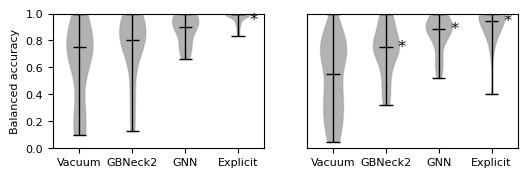

In [47]:
fig, axd = plt.subplot_mosaic([["SetC","SetP"]],figsize=(6,1.75))

ax = axd["SetC"]
violine_plot = ax.violinplot([balanced_accuracies_C_vac,balanced_accuracies_C_gbneck2,balanced_accuracies_C,balanced_accuracies_C_ref],positions=[0,1,2,3],showmedians=True)
ax.text(3.3,np.median(balanced_accuracies_C_ref)-0.05,"*",ha='center',va='center',fontsize=12)
ax.set_ylim(0,1)

ax.set_ylabel("Balanced accuracy")

ax.set_xticks([0,1,2,3],["Vac","GBNeck-2","GNN","Reference"],rotation=0)

for partname in ('cbars','cmins','cmaxes','cmedians'):
    vp = violine_plot[partname]
    vp.set_edgecolor("black")
    vp.set_linewidth(1)

for vp in violine_plot['bodies']:
    vp.set_facecolor("black")
    vp.set_edgecolor("grey")
    vp.set_linewidth(1)

ax = axd["SetP"]
ax.get_yaxis().set_visible(False)
violine_plot = ax.violinplot([balanced_accuracies_vac,balanced_accuracies_gbneck2,balanced_accuracies,balanced_accuracies_ref],positions=[0,1,2,3],showmedians=True)
for partname in ('cbars','cmins','cmaxes','cmedians'):
    vp = violine_plot[partname]
    vp.set_edgecolor("black")
    vp.set_linewidth(1)

for vp in violine_plot['bodies']:
    vp.set_facecolor("black")
    vp.set_edgecolor("grey")
    vp.set_linewidth(1)

ax.text(1.3,np.median(balanced_accuracies_gbneck2),"*",ha='center',va='center',fontsize=12)
ax.text(2.3,np.median(balanced_accuracies),"*",ha='center',va='center',fontsize=12)
ax.text(3.3,np.median(balanced_accuracies_ref),"*",ha='center',va='center',fontsize=12)

for ax in axd.values():
    ax.set_xticks([0,1,2,3],["Vacuum","GBNeck2","GNN","Explicit"],rotation=0)
    ax.set_ylim(0,1)
    ax.set_xlim(-0.5,3.5)

plt.savefig(f"{plot_folder}/Simulated_Ensemble_comparison.pdf",bbox_inches="tight")

In [48]:
np.nanmedian(balanced_accuracies_C_ref),np.nanmedian(balanced_accuracies_C),np.nanmedian(balanced_accuracies_C_gbneck2), np.nanmedian(balanced_accuracies_C_vac)

(1.0, 0.9, 0.80625, 0.75)

In [50]:
np.nanmedian(balanced_accuracies_ref),np.nanmedian(balanced_accuracies),np.nanmedian(balanced_accuracies_gbneck2), np.nanmedian(balanced_accuracies_vac)

(0.9409722222222222, 0.8854895104895104, 0.75, 0.5535714285714286)